**GOAL**:
- get relative positions of each of the hooves
- For Zeni algorithm

In [1]:
import numpy as np
import pandas as pd
# import deeplabcut
# import torch
from pathlib import Path

In [2]:
h5_file = 'processed_vids/vid1_superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_.h5'
pose_data = pd.read_hdf(h5_file)

pose_data = pose_data.sort_index(axis=1)

In [3]:
pose_data

scorer      superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_  \
individuals                                                     animal0   
bodyparts                                                     back_base   
coords                                                       likelihood   
0                                                     0.187797            
1                                                     0.171946            
2                                                     0.152684            
3                                                     0.243810            
4                                                     0.224923            
...                                                        ...            
1221                                                 -1.000000            
1222                                                 -1.000000            
1223                                                 -1.000000            
1224                                                 -1.000000            
1225                                                 -1.000000            

scorer                                                                  \
individuals                                                              
bodyparts                             back_end                           
coords                x           y likelihood           x           y   
0            380.000000  332.000000   0.859222  224.000000  362.000000   
1            389.742188  338.554688   0.913442  228.304688  373.148438   
2            394.312500  344.382812   0.836711  233.062500  381.898438   
3            380.460938  358.687500   0.877416  227.304688  393.937500   
4            383.218750  372.218750   0.878291  232.093750  407.093750   
...                 ...         ...        ...         ...         ...   
1221          -1.000000   -1.000000  -1.000000   -1.000000   -1.000000   
1222          -1.000000   -1.000000  -1.000000   -1.000000   -1.000000   
1223          -1.000000   -1.000000  -1.000000   -1.000000   -1.000000   
1224          -1.000000   -1.000000  -1.000000   -1.000000   -1.000000   
1225          -1.000000   -1.000000  -1.000000   -1.000000   -1.000000   

scorer                                                            ...  \
individuals                                                       ...   
bodyparts   back_left_knee                         back_left_paw  ...   
coords          likelihood           x           y    likelihood  ...   
0                 0.508749  266.000000  422.000000      0.281677  ...   
1                 0.642978  262.898438  425.039062      0.553271  ...   
2                 0.466613  249.187500  440.851562      0.202996  ...   
3                 0.625021  244.976562  452.687500      0.358248  ...   
4                 0.534443  214.656250  471.031250      0.252075  ...   
...                    ...         ...         ...           ...  ...   
1221             -1.000000   -1.000000   -1.000000     -1.000000  ...   
1222             -1.000000   -1.000000   -1.000000     -1.000000  ...   
1223             -1.000000   -1.000000   -1.000000     -1.000000  ...   
1224             -1.000000   -1.000000   -1.000000     -1.000000  ...   
1225             -1.000000   -1.000000   -1.000000     -1.000000  ...   

scorer                                                                  \
individuals                                                              
bodyparts      tail_end throat_base                         throat_end   
coords                y  likelihood           x           y likelihood   
0            200.000000    0.104913  410.000000  338.000000   0.071436   
1            211.710938    0.086224  418.570312  361.617188   0.044909   
2            221.117188    0.103398  405.062500  365.820312   0.041861   
3            458.562500    0.064214  392.242188  393.937500   0.055977   
4            244.343750    0.105481  406.468750  383.843750   0.055029   
.

In [4]:
bodyparts = pose_data.columns.get_level_values('bodyparts').unique()
print("Body parts:", bodyparts)

Body parts: Index(['back_base', 'back_end', 'back_left_knee', 'back_left_paw',
       'back_left_thai', 'back_middle', 'back_right_knee', 'back_right_paw',
       'back_right_thai', 'belly_bottom', 'body_middle_left',
       'body_middle_right', 'front_left_knee', 'front_left_paw',
       'front_left_thai', 'front_right_knee', 'front_right_paw',
       'front_right_thai', 'left_antler_base', 'left_antler_end',
       'left_earbase', 'left_earend', 'left_eye', 'lower_jaw',
       'mouth_end_left', 'mouth_end_right', 'neck_base', 'neck_end', 'nose',
       'right_antler_base', 'right_antler_end', 'right_earbase',
       'right_earend', 'right_eye', 'tail_base', 'tail_end', 'throat_base',
       'throat_end', 'upper_jaw'],
      dtype='object', name='bodyparts')


In [5]:
# Define paws and their reference points
front_paws = ['front_left_paw', 'front_right_paw']
back_paws = ['back_left_paw', 'back_right_paw']
front_ref = 'back_base'
back_ref = 'tail_base'

# Get coordinate levels (typically 'x', 'y', 'likelihood')
coords = pose_data.columns.get_level_values('coords').unique()
print("Coordinate columns:", coords)

Coordinate columns: Index(['likelihood', 'x', 'y'], dtype='object', name='coords')


In [6]:
# Function to extract coordinates for a body part
def get_coords(df, bodypart, coord='x'):
    """Extract coordinates for a specific body part."""
    scorer = df.columns.get_level_values(0).unique()[0]
    individual = df.columns.get_level_values(1).unique()[0]

    coords = df[(scorer, individual, bodypart)][[coord]]

    return coords


# Extract reference point coordinates
back_base_x = get_coords(pose_data, front_ref, 'x')
back_base_y = get_coords(pose_data, front_ref, 'y')
tail_base_x = get_coords(pose_data, back_ref, 'x')
tail_base_y = get_coords(pose_data, back_ref, 'y')

print(f"Reference points extracted:")
print(f"  {front_ref}: {len(back_base_x)} frames")
print(f"  {back_ref}: {len(tail_base_x)} frames")

Reference points extracted:
  back_base: 1226 frames
  tail_base: 1226 frames


In [7]:
# Create new dataframe with same structure as original, including relative positions as new bodyparts
# Start with a copy of the original data
pose_data_with_rel = pose_data.copy()

scorer = pose_data.columns.get_level_values(0).unique()[0]
individual = pose_data.columns.get_level_values(1).unique()[0]

# Calculate relative positions for front paws (relative to back_base)
for paw in front_paws:
    paw_x = get_coords(pose_data, paw, 'x')
    paw_y = get_coords(pose_data, paw, 'y')
    
    # Create new bodypart name for relative position
    rel_bodypart = f'{paw}_rel'
    
    # Add relative x and y coordinates with same MultiIndex structure
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'x')] = paw_x - back_base_x
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'y')] = paw_y - back_base_y
    # Set likelihood to same as original paw
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'likelihood')] = pose_data_with_rel[(scorer, individual, paw, 'likelihood')]

# Calculate relative positions for back paws (relative to tail_base)
for paw in back_paws:
    paw_x = get_coords(pose_data, paw, 'x')
    paw_y = get_coords(pose_data, paw, 'y')
    
    # Create new bodypart name for relative position
    rel_bodypart = f'{paw}_rel'
    
    # Add relative x and y coordinates with same MultiIndex structure
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'x')] = paw_x - tail_base_x
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'y')] = paw_y - tail_base_y
    # Set likelihood to same as original paw
    pose_data_with_rel[(scorer, individual, rel_bodypart, 'likelihood')] = pose_data_with_rel[(scorer, individual, paw, 'likelihood')]

# Sort columns lexicographically to maintain proper MultiIndex order
pose_data_with_rel = pose_data_with_rel.sort_index(axis=1)

print("Dataframe with relative positions created:")
print(f"Original shape: {pose_data.shape}")
print(f"New shape: {pose_data_with_rel.shape}")
print(f"\nNew bodyparts added:")
new_bodyparts = [bp for bp in pose_data_with_rel.columns.get_level_values('bodyparts').unique() 
                 if bp not in pose_data.columns.get_level_values('bodyparts').unique()]
print(new_bodyparts)
print(f"\nFirst few columns with new bodyparts:")
print(pose_data_with_rel.columns[pose_data_with_rel.columns.get_level_values('bodyparts').isin(new_bodyparts)][:6].tolist())

Dataframe with relative positions created:
Original shape: (1226, 117)
New shape: (1226, 129)

New bodyparts added:
['back_left_paw_rel', 'back_right_paw_rel', 'front_left_paw_rel', 'front_right_paw_rel']

First few columns with new bodyparts:
[('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_left_paw_rel', 'likelihood'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_left_paw_rel', 'x'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_left_paw_rel', 'y'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_right_paw_rel', 'likelihood'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_right_paw_rel', 'x'), ('superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_', 'animal0', 'back_right_paw_rel', 'y')]


In [9]:
bodypart_level = pose_data_with_rel.columns.names.index('bodyparts')
rel_data = pose_data_with_rel[[col for col in pose_data_with_rel.columns if 'rel' in col[bodypart_level]]]
rel_data

scorer      superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_  \
individuals                                                     animal0   
bodyparts                                             back_left_paw_rel   
coords                                                       likelihood   
0                                                     0.281677            
1                                                     0.553271            
2                                                     0.202996            
3                                                     0.358248            
4                                                     0.252075            
...                                                        ...            
1221                                                 -1.000000            
1222                                                 -1.000000            
1223                                                 -1.000000            
1224                                                 -1.000000            
1225                                                 -1.000000            

scorer                                                                      \
individuals                                                                  
bodyparts                         back_right_paw_rel                         
coords               x          y         likelihood          x          y   
0            66.000000  72.000000           0.325954  54.000000  66.000000   
1            51.890625  57.656250           0.602561  51.890625  63.421875   
2            53.750000  69.671875           0.429349  37.625000  75.031250   
3            35.343750  64.625000           0.551316  35.343750  82.250000   
4           -11.625000  63.937500           0.545398  29.062500  75.562500   
...                ...        ...                ...        ...        ...   
1221          0.000000   0.000000          -1.000000   0.000000   0.000000   
1222          0.000000   0.000000          -1.000000   0.000000   0.000000   
1223          0.000000   0.000000          -1.000000   0.000000   0.000000   
1224          0.000000   0.000000          -1.000000   0.000000   0.000000   
1225          0.000000   0.000000          -1.000000   0.000000   0.000000   

scorer                                                                    \
individuals                                                                
bodyparts   front_left_paw_rel                       front_right_paw_rel   
coords              likelihood         x           y          likelihood   
0                     0.660967   6.00000  108.000000            0.571348   
1                     0.699563   0.00000   92.250000            0.794029   
2                     0.707563   0.00000  112.546875            0.648530   
3                     0.706006  11.78125  105.750000            0.558682   
4                     0.665610  11.62500  110.437500            0.633792   
...                        ...       ...         ...                 ...   
1221                 -1.000000   0.00000    0.000000           -1.000000   
1222                 -1.000000   0.00000    0.000000           -1.000000   
1223                 -1.000000   0.00000    0.000000           -1.000000   
1224                 -1.000000   0.00000    0.000000           -1.000000   
1225                 -1.000000   0.00000    0.000000           -1.000000   

scorer                              
individuals                         
bodyparts                           
coords               x           y  
0             6.000000  108.000000  
1             5.765625  109.546875  
2             0.000000  112.546875  
3            11.781250  117.500000  
4            17.437500  122.062500  
...                ...         ...  
1221          0.000000    0.000000  
1222          0.000000    0.000000  
1223          0.000000    0.000000  
1224          0.000000    0.000000  
1225          0.000000    0.000000  

[1226 

In [10]:
# Display summary statistics for relative positions
print("\nSummary statistics for relative positions:")
print(rel_data.describe())


Summary statistics for relative positions:
scorer      superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_  \
individuals                                                     animal0   
bodyparts                                             back_left_paw_rel   
coords                                                       likelihood   
count                                              1226.000000            
mean                                                  0.591132            
std                                                   0.569297            
min                                                  -1.000000            
25%                                                   0.719519            
50%                                                   0.806974            
75%                                                   0.854121            
max                                                   0.969674            

scorer                                                 

In [11]:
# Optional: Save the dataframe with relative positions
# Uncomment the line below to save to HDF5
# pose_data_with_rel.to_hdf('processed_vids/pose_data_with_relative_positions.h5', key='pose_data', mode='w')

# Or save to CSV (note: CSV doesn't preserve MultiIndex structure well)
# pose_data_with_rel.to_csv('processed_vids/pose_data_with_relative_positions.csv', index=True)


In [12]:
from utils.vis import *
import importlib
import utils.vis

# After making changes to utils/vis.py, reload it:
importlib.reload(utils.vis)

<module 'utils.vis' from 'c:\\Users\\jexia\\OneDrive\\Documents\\projects\\datafawn\\utils\\vis.py'>

In [21]:
def compare_abs_and_rel(df, paw, min_likelihood=0.25):
    fig = plot_bodypart_movement(df, paw, individual='animal0', min_likelihood=min_likelihood)
    plt.show()

    fig = plot_bodypart_movement(df, paw+"_rel", individual='animal0', min_likelihood=min_likelihood)
    plt.show()

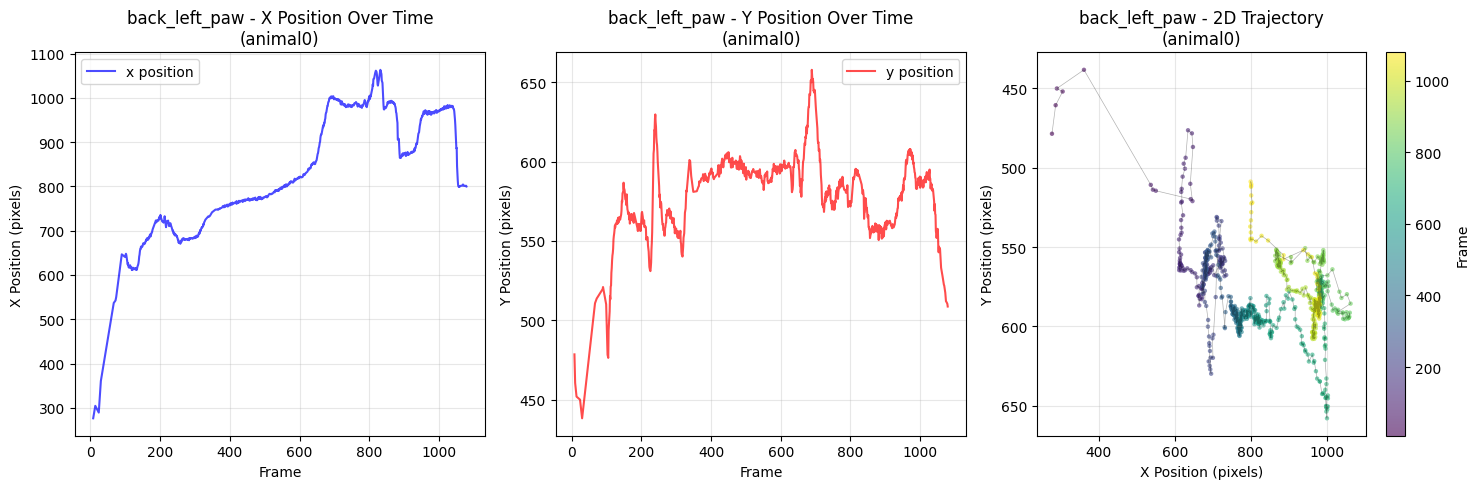

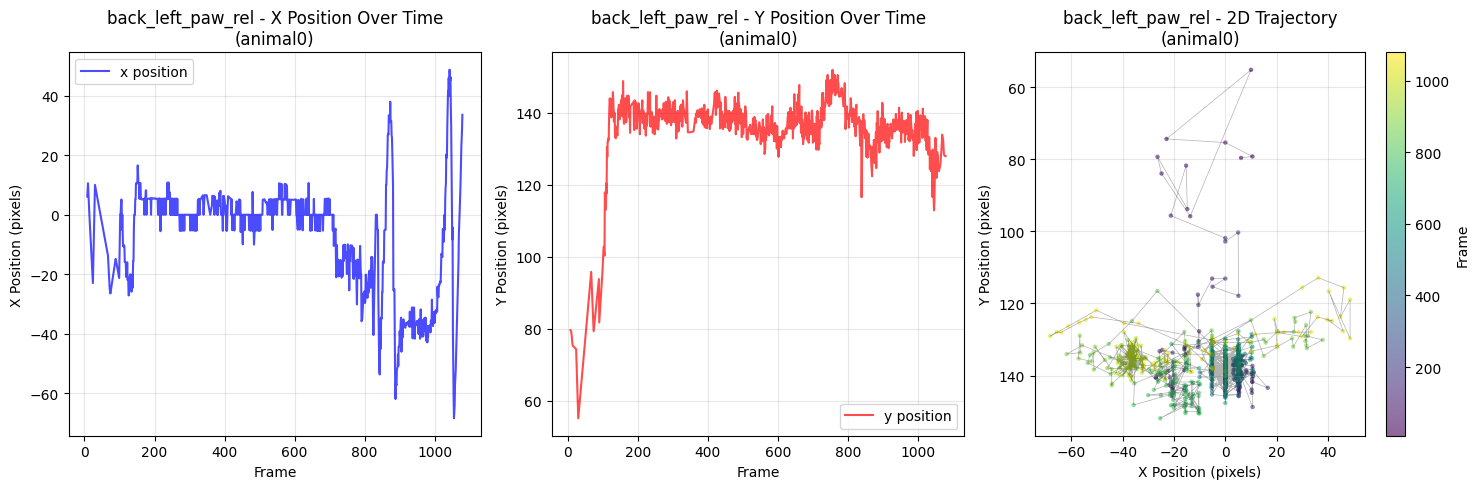

In [26]:
compare_abs_and_rel(pose_data_with_rel, 'back_left_paw', min_likelihood=0.75)

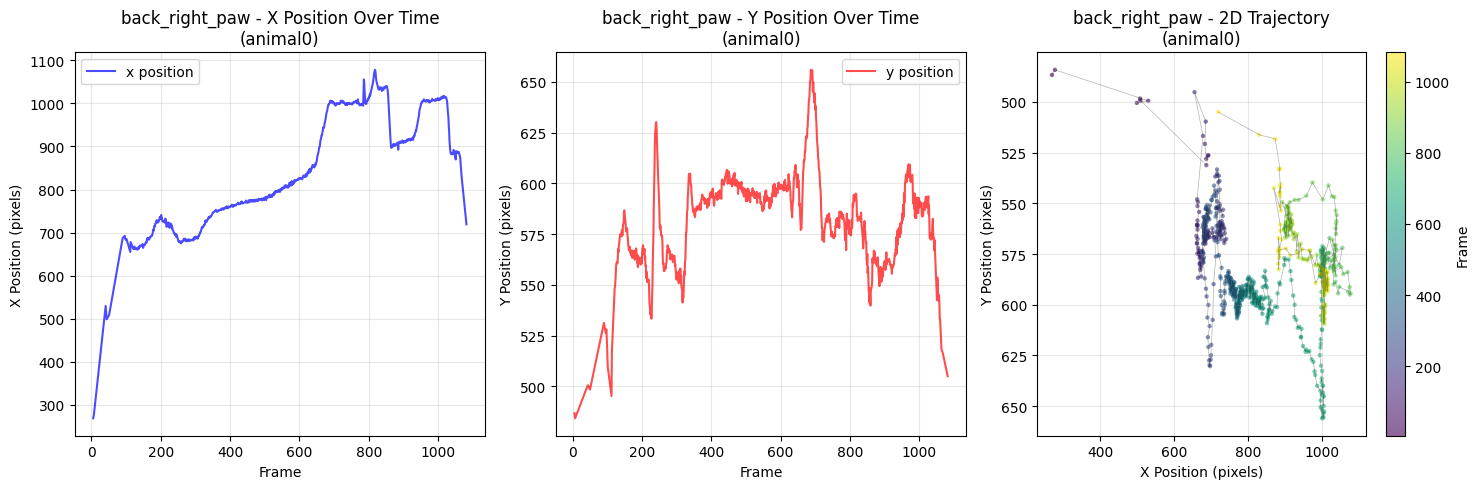

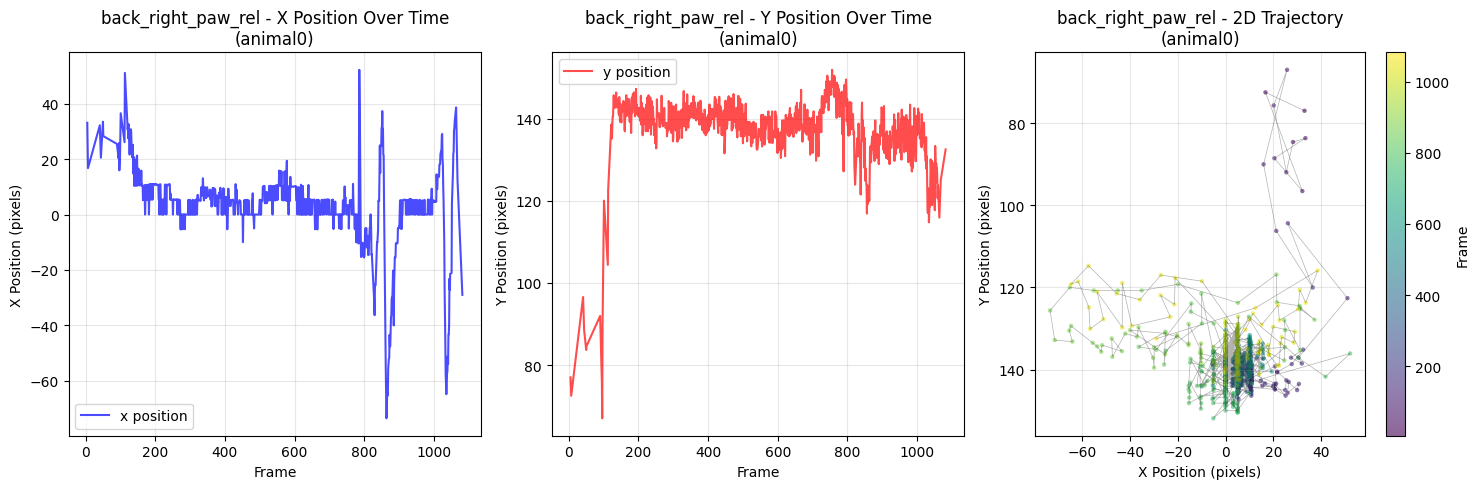

In [27]:
compare_abs_and_rel(pose_data_with_rel, 'back_right_paw', min_likelihood=0.75)

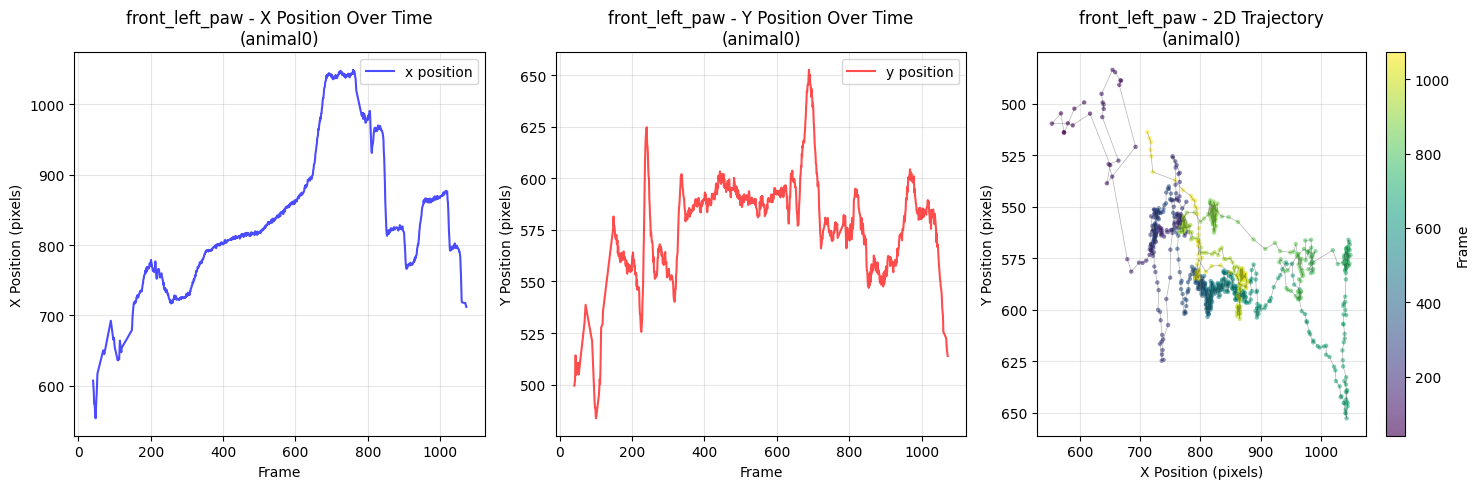

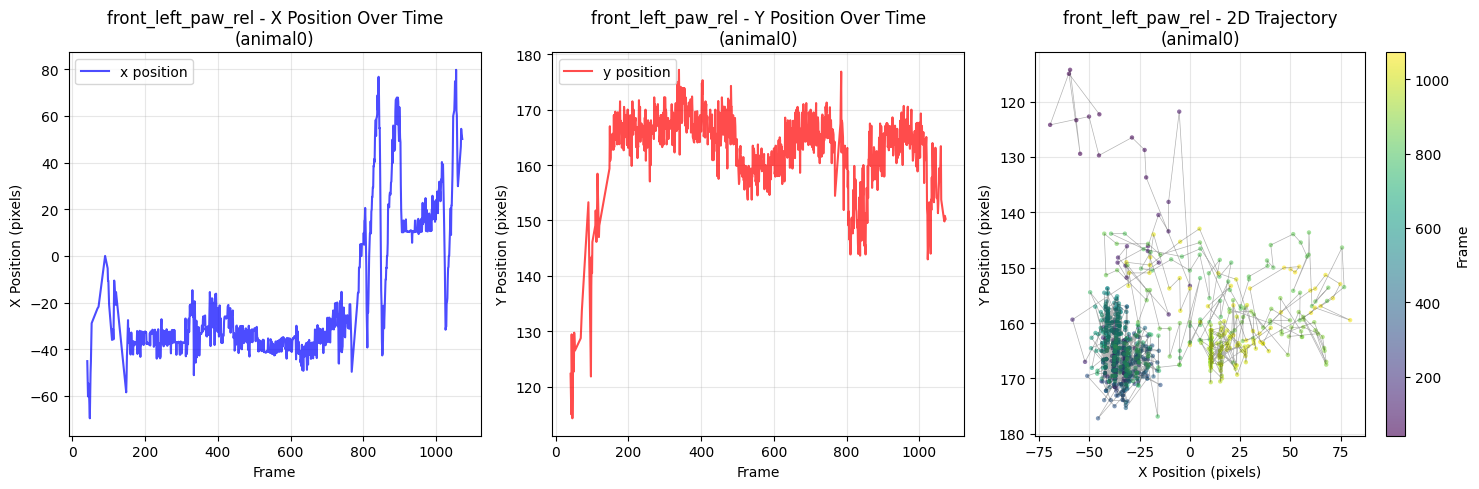

In [28]:
compare_abs_and_rel(pose_data_with_rel, 'front_left_paw', min_likelihood=0.75)

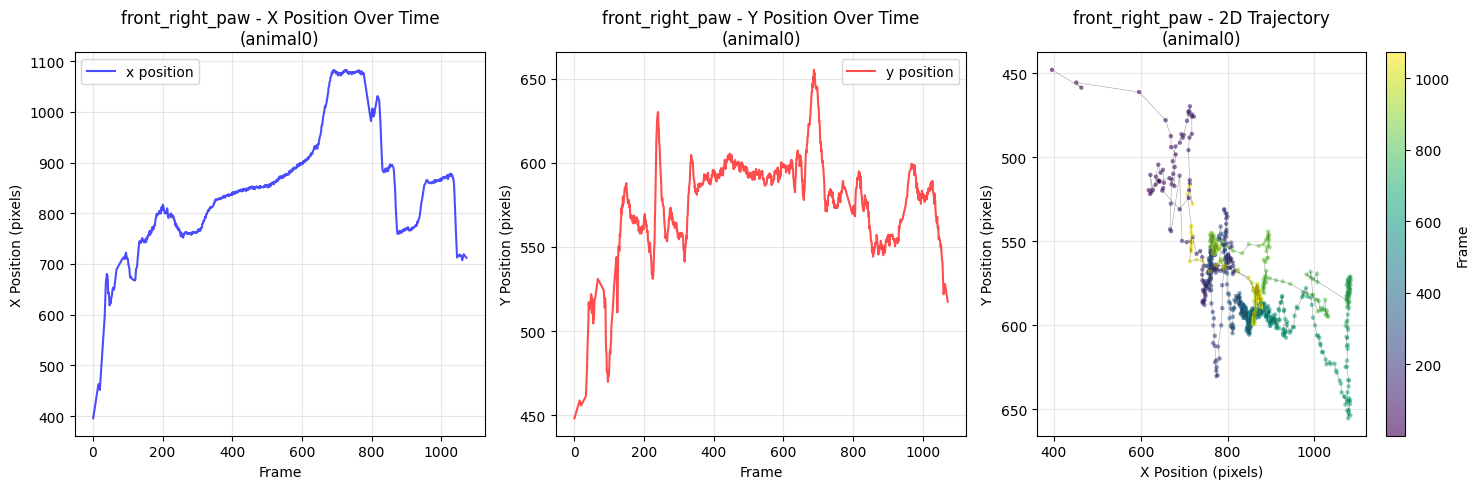

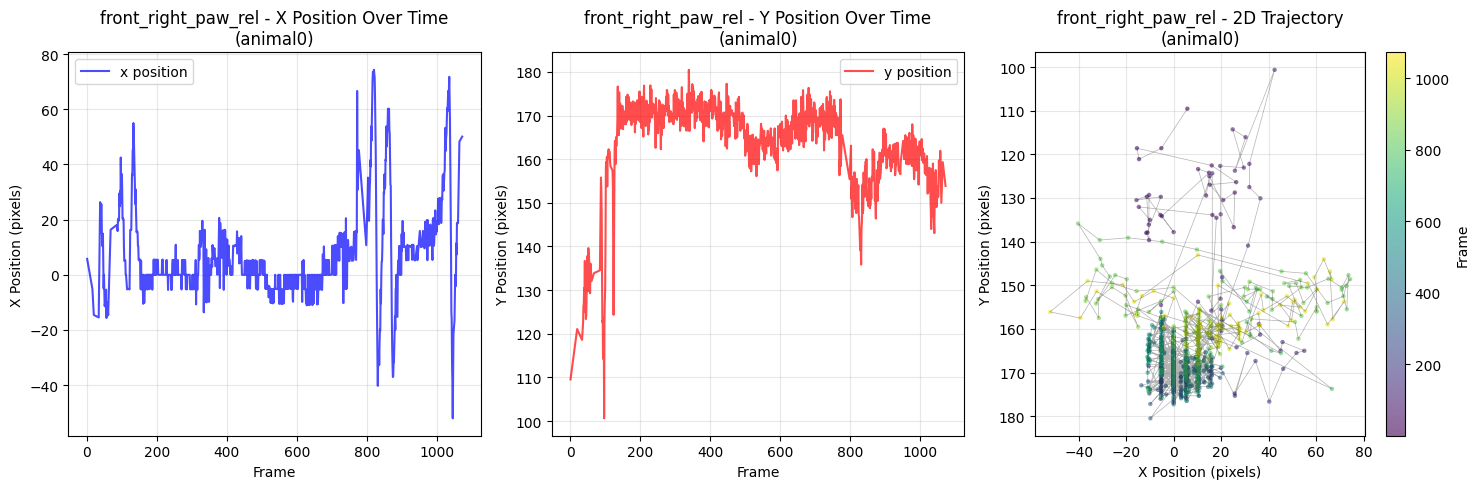

In [29]:
compare_abs_and_rel(pose_data_with_rel, 'front_right_paw', min_likelihood=0.75)